<a href="https://colab.research.google.com/github/yoshiho0/AI-for-transportation/blob/main/xgboost__bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

xgboost version: 3.0.4
Data shape: (2179, 9)
Columns: ['Arrival_time', 'Stop_id', 'Bus_id', 'Line_id', 'Arrival_delay', 'Dwell_time', 'Scheduled_travel_time', 'Upstream_stop_delay', 'Recurrent_delay']
Arrival_time parsing skipped: time data "13/05/2022 06:33" doesn't match format "%m/%d/%Y %H:%M", at position 929. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
Using numeric features: ['Dwell_time', 'Scheduled_travel_time', 'Upstream_stop_delay', 'Recurrent_delay']
Best iteration: 876
Best score (val MAE): 4.450568561226044
MAE : 4.522
RMSE: 8.636
R^2 : 0.945


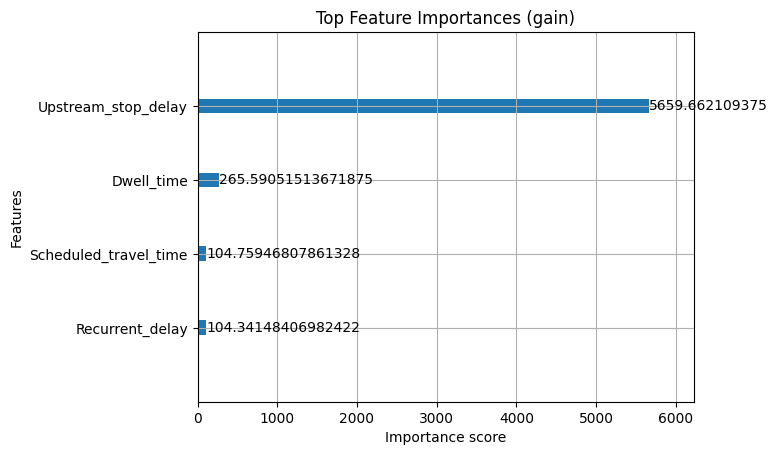

Saved model -> xgb_bus_delay.json


In [7]:
# ==== Train & Evaluate Bus Arrival Delay with XGBoost (core API) ====
# Goal: Predict Arrival_delay [minutes] as a regression problem (MAE as main metric)
# Note: Works with xgboost==3.0.4 (sklearn wrapper callbacks not required)

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

print("xgboost version:", xgb.__version__)


# 1) Load dataset (local file first → fallback to GitHub CSV)

LOCAL = "Exercise2BusData.csv"
URL   = "https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/Exercise_2_regression_model/Exercise2BusData.csv"

if os.path.exists(LOCAL):
    df = pd.read_csv(LOCAL)
else:
    df = pd.read_csv(URL)

print("Data shape:", df.shape)
print("Columns:", list(df.columns))


# 2) Feature preparation (minimal: drop IDs + extract hour/dow from Arrival_time)

target_col = "Arrival_delay"
id_cols = ["Stop_id", "Bus_id", "Line_id"]  # drop if present

# Time features
if "Arrival_time" in df.columns:
    try:
        t = pd.to_datetime(df["Arrival_time"])
        df["hour"] = t.dt.hour
        df["dow"]  = t.dt.dayofweek
        df["is_weekend"] = df["dow"].isin([5,6]).astype(int)
    except Exception as e:
        print("Arrival_time parsing skipped:", e)
    # Drop original string column since it’s not directly usable
    df.drop(columns=["Arrival_time"], inplace=True, errors="ignore")

# Drop ID columns if they exist
for c in id_cols:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# Target variable
if target_col not in df.columns:
    raise ValueError(f"{target_col} not found in dataframe. Check column names.")
y = df[target_col].astype(float).clip(-60, 120)  # light clipping to reduce extreme outliers
X = df.drop(columns=[target_col])

# Keep numeric features only (avoid errors from categorical variables)
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[num_cols].copy()
print("Using numeric features:", num_cols)

# Simple missing value handling
for c in X.columns:
    if X[c].isna().any():
        X[c] = X[c].fillna(X[c].median())


# 3) Train/Test split + validation split for early stopping

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42
)


# 4) Core API: convert to DMatrix → train with early stopping

dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test)

params = {
    "objective": "reg:squarederror",
    "eta": 0.02,              # learning rate
    "max_depth": 6,
    "min_child_weight": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 45.0,           # L2 regularization (reg_lambda)
    "tree_method": "hist",
    "eval_metric": "mae",     # early stopping monitored on this metric
    "seed": 42,
}

watchlist = [(dval, "valid")]
num_round = 4000  # train with a large upper bound, early stopping will cut it short

booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=watchlist,
    early_stopping_rounds=100,
    verbose_eval=False
)

best_it = booster.best_iteration if booster.best_iteration is not None else booster.num_boost_round - 1
best_score = booster.best_score if hasattr(booster, "best_score") else None
print(f"Best iteration: {best_it}")
print(f"Best score (val MAE): {best_score}")


# 5) Test evaluation (predict up to best_iteration)

y_pred = booster.predict(dtest, iteration_range=(0, best_it + 1))
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # manually compute RMSE (compatibility with older sklearn)
r2   = r2_score(y_test, y_pred)

print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2 : {r2:.3f}")


# 6) Feature importance plot (top 20 by gain)

try:
    xgb.plot_importance(booster, importance_type="gain", max_num_features=20)
    plt.title("Top Feature Importances (gain)")
    plt.show()
except Exception as e:
    print("Feature importance plot skipped:", e)


# 7) Save model (optional)

booster.save_model("xgb_bus_delay.json")
print("Saved model -> xgb_bus_delay.json")


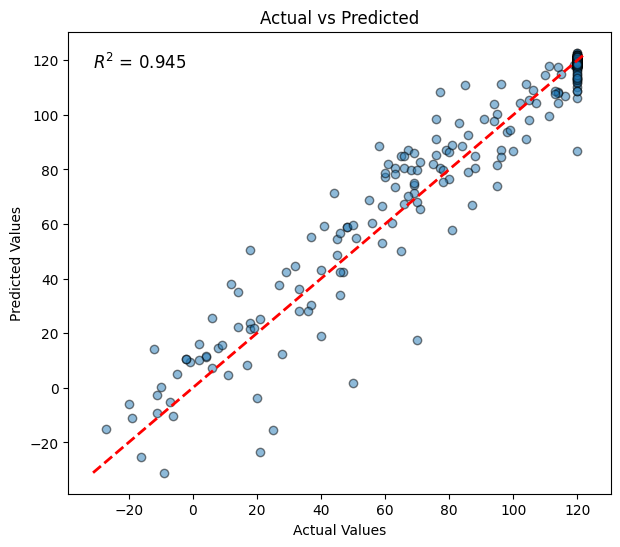

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors="k")

# 参考線（理想線 y=x）
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', lw=2)

# ラベルなど
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")

# R² を表示
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
plt.text(lims[0], lims[1], f"$R^2$ = {r2:.3f}", fontsize=12,
         verticalalignment='top', horizontalalignment='left')

plt.show()

Loaded: day.csv
Feature count: 22
[1/14] valid MAE(log)=0.40167, params={'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 8, 'lambda': 3.0, 'gamma': 0.5, 'eta': 0.03, 'colsample_bytree': 0.9, 'alpha': 0.0}
[2/14] valid MAE(log)=0.24532, params={'subsample': 0.8, 'min_child_weight': 3, 'max_depth': 8, 'lambda': 3.0, 'gamma': 0.0, 'eta': 0.05, 'colsample_bytree': 0.8, 'alpha': 0.0}
[3/14] valid MAE(log)=0.27153, params={'subsample': 0.8, 'min_child_weight': 3, 'max_depth': 8, 'lambda': 1.0, 'gamma': 0.0, 'eta': 0.03, 'colsample_bytree': 0.8, 'alpha': 0.1}
[4/14] valid MAE(log)=0.29340, params={'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 8, 'lambda': 3.0, 'gamma': 0.0, 'eta': 0.03, 'colsample_bytree': 0.9, 'alpha': 0.1}
[5/14] valid MAE(log)=0.30114, params={'subsample': 0.8, 'min_child_weight': 1, 'max_depth': 8, 'lambda': 3.0, 'gamma': 0.0, 'eta': 0.05, 'colsample_bytree': 0.8, 'alpha': 0.1}
[6/14] valid MAE(log)=0.26182, params={'subsample': 0.8, 'min_child_weight': 3, '

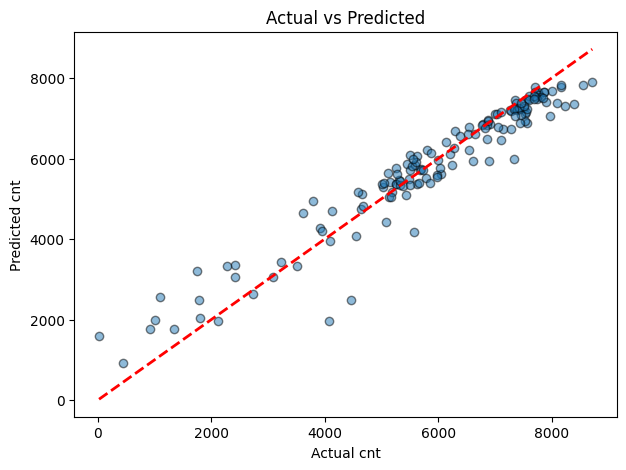

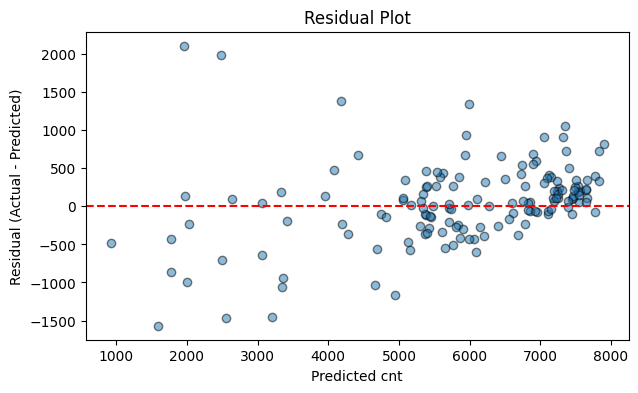

In [4]:
# ==== Bike Sharing demand with XGBoost: high-accuracy recipe ====
# ・堅牢ローダー（ローカル/URL/Colabアップロード）
# ・特徴量: 周期(sin/cos) + lag1/7/14 + ma7/14 + diff1/7 + 交互作用(temp×hum etc.)
# ・カテゴリ: one-hot（season/weathersit/holiday/workingday/yr/mnth/weekday があれば）
# ・目的変数: log1p(cnt) 学習 → 予測は expm1 で戻す
# ・検証: 時系列 60/20/20（train/valid/test）＋ early stopping
# ・チューニング: ランダム探索（10〜20本）→ best を本学習 → テスト評価

import os, numpy as np, pandas as pd, xgboost as xgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import ParameterSampler

# ------------------------------------------------------------
# 1) day.csv loader
# ------------------------------------------------------------
CANDS = [
    "day.csv", "/content/day.csv",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/day.csv",
    "https://raw.githubusercontent.com/laxmena/Bike-Sharing-Dataset/master/day.csv",
]
df, last_err = None, None
for src in CANDS:
    try:
        if src.startswith("http") or os.path.exists(src):
            df = pd.read_csv(src)
            print(f"Loaded: {src}")
            break
    except Exception as e:
        last_err = e
if df is None:
    try:
        from google.colab import files
        print("day.csv をアップロードしてください…")
        up = files.upload()
        df = pd.read_csv(next(iter(up)))
    except Exception as e:
        raise FileNotFoundError(f"day.csv が見つかりません: {last_err or e}")

# ------------------------------------------------------------
# 2) 基本整形 & 目的変数
# ------------------------------------------------------------
df["dteday"] = pd.to_datetime(df["dteday"])
df = df.sort_values("dteday").reset_index(drop=True)

y_raw = df["cnt"].astype(float)
y_log = np.log1p(y_raw)     # ★ log 学習（外れ値耐性）

# ------------------------------------------------------------
# 3) 特徴量設計
# ------------------------------------------------------------
X = df.copy()

# 時間・周期
X["month"] = X["dteday"].dt.month
X["dow"]   = X["dteday"].dt.dayofweek
X["trend"] = (X["dteday"] - X["dteday"].min()).dt.days
X["sin_month"] = np.sin(2*np.pi*X["month"]/12.0)
X["cos_month"] = np.cos(2*np.pi*X["month"]/12.0)
X["sin_dow"]   = np.sin(2*np.pi*X["dow"]/7.0)
X["cos_dow"]   = np.cos(2*np.pi*X["dow"]/7.0)

# ラグ/移動平均/差分（リーク防止：y_raw から生成）
for k in [1,7,14]:
    X[f"lag{k}"] = y_raw.shift(k)
X["ma7"]  = y_raw.shift(1).rolling(7,  min_periods=1).mean()
X["ma14"] = y_raw.shift(1).rolling(14, min_periods=1).mean()
X["diff1"] = y_raw.diff(1)
X["diff7"] = y_raw.diff(7)
for c in ["lag1","lag7","lag14","ma7","ma14","diff1","diff7"]:
    X[c] = X[c].fillna(0.0)

# 交互作用（天候の非線形：UCI day.csv は0-1スケール）
for a,b in [("temp","hum"),("hum","windspeed"),("temp","windspeed"),("atemp","hum")]:
    if a in X.columns and b in X.columns:
        X[f"{a}_x_{b}"] = X[a]*X[b]

# 低リーク：casual/registered は不使用、日付/目的変数も除外
X = X.drop(columns=[c for c in ["instant","dteday","cnt","casual","registered"] if c in X.columns])

# one-hot（あれば）
cat_cols = [c for c in ["season","weathersit","workingday","holiday","yr","mnth","weekday"] if c in df.columns]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# 数値だけに統一
X = X.select_dtypes(include=[np.number]).copy()
print("Feature count:", X.shape[1])

# ------------------------------------------------------------
# 4) 時系列 split: 60/20/20
# ------------------------------------------------------------
n = len(X)
i_tr_end, i_val_end = int(n*0.60), int(n*0.80)
X_train, y_train_log = X.iloc[:i_tr_end],          y_log.iloc[:i_tr_end]
X_val,   y_val_log   = X.iloc[i_tr_end:i_val_end], y_log.iloc[i_tr_end:i_val_end]
X_test,  y_test      = X.iloc[i_val_end:],         y_raw.iloc[i_val_end:]    # ★評価は元スケール

dtrain, dval, dtest = xgb.DMatrix(X_train, y_train_log), xgb.DMatrix(X_val, y_val_log), xgb.DMatrix(X_test)

# ------------------------------------------------------------
# 5) ランダム探索（10〜20本で当たりを掴む）
# ------------------------------------------------------------
base = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "tree_method": "hist",   # GPUなら 'gpu_hist'
    "max_bin": 512,
    "seed": 42,
}
space = {
    "eta":              [0.02, 0.03, 0.05],
    "max_depth":        [6, 8],
    "min_child_weight": [1, 2, 3],
    "subsample":        [0.8, 0.9],
    "colsample_bytree": [0.8, 0.9],
    "lambda":           [1.0, 3.0],
    "alpha":            [0.0, 0.1],
    "gamma":            [0.0, 0.5],
}
n_iter = 14   # 時間に応じて 10〜20 など
best = {"score": 1e9, "params": None, "best_it": None}

for i, p in enumerate(ParameterSampler(space, n_iter=n_iter, random_state=42), 1):
    params = {**base, **p}
    booster = xgb.train(params, dtrain,
                        num_boost_round=7000,
                        evals=[(dval,"valid")],
                        early_stopping_rounds=250,
                        verbose_eval=False)
    score = booster.best_score  # valid MAE（log空間）
    if score < best["score"]:
        best.update({"score": score, "params": params, "best_it": booster.best_iteration})
    print(f"[{i}/{n_iter}] valid MAE(log)={score:.5f}, params={p}")

print("\n=== BEST (valid MAE in log space) ===")
print("score :", best["score"])
print("params:", best["params"])
print("best_it:", best["best_it"])

# ------------------------------------------------------------
# 6) best で再学習（train+valid を結合）→ テスト評価
# ------------------------------------------------------------
X_trall = pd.concat([X_train, X_val], axis=0)
y_trall_log = pd.concat([y_train_log, y_val_log], axis=0)
dtrall = xgb.DMatrix(X_trall, y_trall_log)

final = xgb.train(best["params"], dtrall,
                  num_boost_round=best["best_it"]+400,  # 少し余裕を持たせる
                  evals=[(dtrall,"train")],
                  verbose_eval=False)

y_pred_log = final.predict(dtest, iteration_range=(0, best["best_it"]+1))
y_pred = np.expm1(y_pred_log)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"\nTest MAE : {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R^2 : {r2:.3f}")

# ------------------------------------------------------------
# 7) 可視化
# ------------------------------------------------------------
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors="k")
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.xlabel("Actual cnt"); plt.ylabel("Predicted cnt"); plt.title("Actual vs Predicted"); plt.show()

res = y_test - y_pred
plt.figure(figsize=(7,4))
plt.scatter(y_pred, res, alpha=0.5, edgecolors="k")
plt.axhline(0, color="r", linestyle="--")
plt.xlabel("Predicted cnt"); plt.ylabel("Residual (Actual - Predicted)"); plt.title("Residual Plot"); plt.show()
